## Project: Bayesian Non-Parametric Models for Stock Prediction

#### Team Members:
- Asteria Xu (56376452)
- Yufei Shen (29116514)

In [1]:
library(tidyverse) 
library(ggplot2)
library(fGarch)
library(rstan)   

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we 

In [2]:
# Load Data
tsla_data <- read.csv("TSLA.csv")
head(tsla_data)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
3,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
4,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
5,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
6,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


In [3]:
# Ensure Date is in Date format
tsla_data$Date <- as.Date(tsla_data$Date)
tsla_data <- tsla_data[order(tsla_data$Date), ]

# Calculate log returns
tsla_data$Returns <- c(NA, diff(log(tsla_data$Close)))
tsla_data <- na.omit(tsla_data)

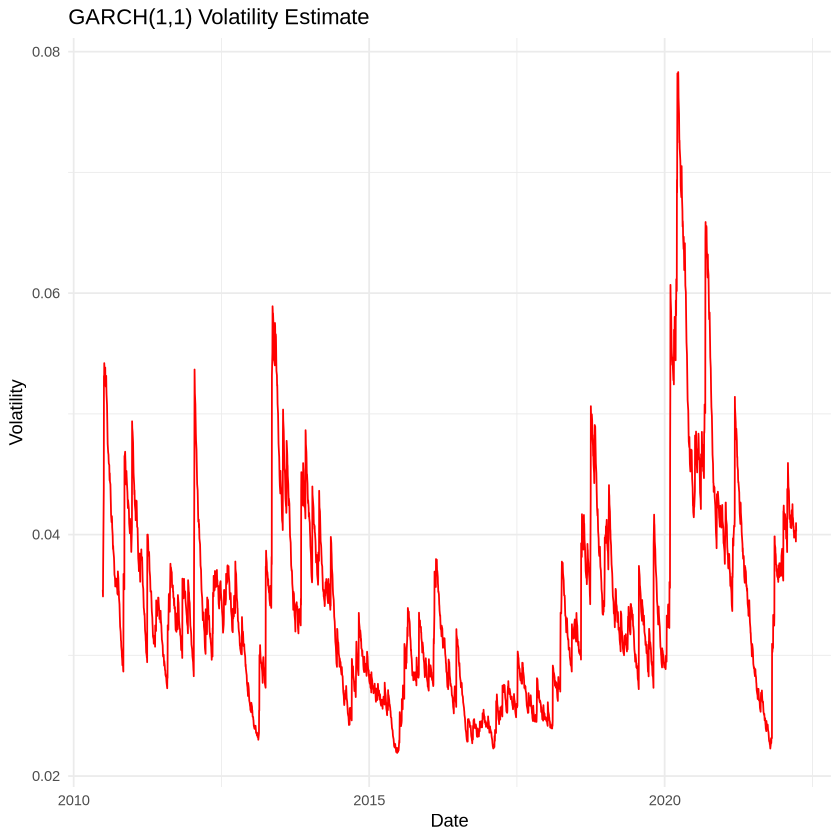

In [4]:
# Fit GARCH(1,1)
fit <- garchFit(~ garch(1,1), data = tsla_data$Returns, trace = FALSE)

# Extract volatility
vol_series <- volatility(fit)

# Coerce to numeric and trim to match length
vol_vector <- as.numeric(vol_series)

# Align lengths
tsla_data <- tail(tsla_data, length(vol_vector))
tsla_data$GARCH_vol <- vol_vector

# Plot
ggplot(tsla_data, aes(x = Date, y = GARCH_vol)) +
  geom_line(color = "red") +
  labs(
    title = "GARCH(1,1) Volatility Estimate",
    x = "Date",
    y = "Volatility"
  ) +
  theme_minimal()

In [5]:
# Standardize returns for better numerical stability
returns <- tsla_data$Returns
mean_return <- mean(returns)
sd_return <- sd(returns)
std_returns <- (returns - mean_return)/sd_return

# Time index
time_index <- as.numeric(tsla_data$Date - min(tsla_data$Date))

# Split into train/test 
n <- length(std_returns)
train_idx <- 1:floor(0.8*n)
test_idx <- (floor(0.8*n)+1):n

In [ ]:
# Prepare data for GP
gp_data <- list(
  N = length(std_returns[train_idx]),
  y = std_returns[train_idx],
  x = time_index[train_idx]/max(time_index)  
)

# Fit GP model
gp_fit <- stan(
  file = "gp_volatility.stan",
  data = gp_data,
  chains = 4,
  iter = 2000,
  warmup = 1000,
  control = list(adapt_delta = 0.9)
)

# Diagnostics
print(gp_fit, pars = c("mu", "alpha", "rho", "sigma"))
stan_trace(gp_fit, pars = c("mu", "alpha", "rho", "sigma"))